# Notebook 2 - EDA y Preparacion de Datos

## Objetivo del notebook
Este notebook valida los artefactos de N1, realiza EDA de calidad/cobertura y prepara tablas limpias para N3 (senales) y N4 (ejecucion y costes).

## Flujo de trabajo
1. Carga y validacion de inputs de N1.
2. EDA de cobertura, calidad, consistencia y retornos.
3. EDA de cambios abruptos de cotizacion para etiquetar eventos extremos.
4. Regla point-in-time, calendario de rebalanceo y construccion de artefactos.
5. Checklist final de readiness para continuar en N3.


## 1) Configuracion del Notebook
### Librerias, estilo y rutas de trabajo
Se definen librerias permitidas, constantes de entrada/salida y reglas de esquema para asegurar consistencia y trazabilidad desde N1.


In [12]:
# Librerias permitidas por el enunciado para analisis y visualizacion.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo uniforme para que todas las figuras sean legibles en la correccion.
sns.set_theme(style="whitegrid", context="talk")

# Artefactos de entrada generados en Notebook_1.
N1_CANONICAL_PATH = "data/processed/sp500_canonical.parquet"
N1_SPY_PATH = "data/raw/spy_yfinance.parquet"
N1_RUNTIME_PATH = "data/processed/n1_runtime_params.csv"

# Artefactos de salida de Notebook_2 para N3 y N4.
OUT_REBALANCE_CALENDAR = "data/processed/n2_rebalance_calendar.csv"
OUT_ELIGIBILITY_FLAGS = "data/processed/n2_eligibility_flags.parquet"
OUT_SIGNALS_INPUT = "data/processed/n2_signals_input.parquet"
OUT_EXECUTION_PRICES = "data/processed/n2_execution_prices.parquet"
OUT_EDA_CHECKS = "data/processed/n2_eda_checks.csv"

# Esquema tecnico minimo del dataset canonico.
CANONICAL_REQUIRED_COLUMNS = [
    "date",
    "symbol",
    "assetid",
    "security_name",
    "sector",
    "industry",
    "subsector",
    "in_sp500",
    "open",
    "high",
    "low",
    "close",
    "volume",
    "unadjusted_close",
]

# Esquema minimo del benchmark para comparativas posteriores.
SPY_REQUIRED_COLUMNS = ["date", "symbol", "open", "high", "low", "close", "volume"]
# Campos criticos para continuidad de calculos de precios y ejecucion.
CRITICAL_COLUMNS = ["date", "symbol", "open", "high", "low", "close", "volume"]


def fail_if(condition: bool, message: str) -> None:
    """Corta la ejecucion cuando se detecta un problema critico."""
    if condition:
        raise ValueError(message)


def record_check(
    rows: list,
    check: str,
    passed: bool,
    details: str,
    critical: bool = True,
) -> None:
    """Registra checks de calidad y aplica fail-fast en checks criticos."""
    rows.append(
        {
            "check": check,
            "passed": bool(passed),
            "critical": bool(critical),
            "details": details,
        }
    )
    fail_if(critical and not passed, f"[{check}] {details}")


## 2) Carga y Validacion de Inputs de N1
### Fail-fast tecnico antes del EDA
Se cargan artefactos canonicos y benchmark, y se validan columnas, unicidad y cobertura temporal minima (incluyendo warm-up de 13 meses).


In [13]:
def load_runtime_params(runtime_path: str) -> dict:
    """Carga parametros de N1 desde CSV key-value."""
    exists = pd.io.common.file_exists(runtime_path)
    fail_if(not exists, f"No existe runtime params de N1: {runtime_path}")

    runtime_df = pd.read_csv(runtime_path)
    fail_if(
        not {"parameter", "value"}.issubset(runtime_df.columns),
        "n1_runtime_params.csv no tiene columnas parameter/value.",
    )

    # Convertimos a diccionario para acceso claro por nombre de parametro.
    runtime_params = dict(zip(runtime_df["parameter"], runtime_df["value"]))
    return runtime_params


def load_n1_artifacts(
    canonical_path: str,
    spy_path: str,
    runtime_path: str,
) -> tuple[dict, pd.DataFrame, pd.DataFrame]:
    """Carga artefactos de N1 que alimentan EDA y preparacion."""
    fail_if(
        not pd.io.common.file_exists(canonical_path),
        f"No existe canonical parquet: {canonical_path}",
    )
    fail_if(
        not pd.io.common.file_exists(spy_path),
        f"No existe benchmark parquet: {spy_path}",
    )

    runtime_params = load_runtime_params(runtime_path)
    canonical_df = pd.read_parquet(canonical_path, engine="pyarrow")
    spy_df = pd.read_parquet(spy_path, engine="pyarrow")

    # Normalizamos tipos para que merges y filtros temporales sean deterministas.
    canonical_df["date"] = pd.to_datetime(canonical_df["date"], errors="coerce")
    spy_df["date"] = pd.to_datetime(spy_df["date"], errors="coerce")
    canonical_df["symbol"] = canonical_df["symbol"].astype("string")
    spy_df["symbol"] = spy_df["symbol"].astype("string")

    return runtime_params, canonical_df, spy_df


def validate_n2_inputs(
    canonical_df: pd.DataFrame,
    spy_df: pd.DataFrame,
    runtime_params: dict,
) -> pd.DataFrame:
    """Valida esquema y cobertura temporal minima para arrancar N2."""
    checks = []

    # 1) Integridad de columnas requeridas.
    missing_canonical = sorted(
        set(CANONICAL_REQUIRED_COLUMNS) - set(canonical_df.columns)
    )
    record_check(
        checks,
        "canonical_required_columns",
        len(missing_canonical) == 0,
        f"missing_columns={missing_canonical}",
    )

    missing_spy = sorted(set(SPY_REQUIRED_COLUMNS) - set(spy_df.columns))
    record_check(
        checks,
        "spy_required_columns",
        len(missing_spy) == 0,
        f"missing_columns={missing_spy}",
    )

    # 2) Unicidad tecnica de la clave temporal del universo.
    duplicate_count = int(canonical_df.duplicated(["date", "symbol"]).sum())
    record_check(
        checks,
        "canonical_date_symbol_unique",
        duplicate_count == 0,
        f"duplicate_rows={duplicate_count}",
    )

    # 3) Cobertura temporal necesaria para el backtest con warm-up.
    backtest_start = pd.Timestamp(runtime_params.get("backtest_start", "2015-01-01"))
    date_min = canonical_df["date"].min()
    date_max = canonical_df["date"].max()

    record_check(
        checks,
        "canonical_contains_backtest_start",
        date_max >= backtest_start,
        f"date_max={date_max.date()} backtest_start={backtest_start.date()}",
    )

    min_required = backtest_start - pd.DateOffset(months=13)
    record_check(
        checks,
        "canonical_has_13m_warmup",
        date_min <= min_required,
        f"date_min={date_min.date()} required_before={min_required.date()}",
    )

    # 4) SPY puede empezar algunos dias despues por calendario bursatil.
    spy_min = spy_df["date"].min()
    spy_max = spy_df["date"].max()
    max_start_gap = int((spy_min - backtest_start).days)
    record_check(
        checks,
        "spy_start_alignment",
        max_start_gap <= 7,
        (
            f"spy_min={spy_min.date()} backtest_start={backtest_start.date()} "
            f"gap_days={max_start_gap}"
        ),
    )

    alignment_days = int((spy_max - backtest_start).days)
    record_check(
        checks,
        "spy_has_useful_horizon",
        alignment_days > 365,
        f"days_from_backtest_start={alignment_days}",
    )

    checks_df = pd.DataFrame(checks)
    return checks_df


# Carga principal de artefactos de N1.
runtime_params, df, spy_df = load_n1_artifacts(
    canonical_path=N1_CANONICAL_PATH,
    spy_path=N1_SPY_PATH,
    runtime_path=N1_RUNTIME_PATH,
)

n2_checks_df = validate_n2_inputs(df, spy_df, runtime_params)
print("N2 input checks:")
print(n2_checks_df.to_string(index=False))
print("\nCanonical shape:", df.shape)
print("SPY shape:", spy_df.shape)
print("Backtest start:", runtime_params.get("backtest_start", "2015-01-01"))


N2 input checks:
                            check  passed  critical                                                 details
       canonical_required_columns    True      True                                      missing_columns=[]
             spy_required_columns    True      True                                      missing_columns=[]
     canonical_date_symbol_unique    True      True                                        duplicate_rows=0
canonical_contains_backtest_start    True      True           date_max=2026-01-30 backtest_start=2015-01-01
         canonical_has_13m_warmup    True      True          date_min=1990-01-02 required_before=2013-12-01
              spy_start_alignment    True      True spy_min=2015-01-02 backtest_start=2015-01-01 gap_days=1
           spy_has_useful_horizon    True      True                           days_from_backtest_start=4067

Canonical shape: (7250110, 14)
SPY shape: (2799, 7)
Backtest start: 2015-01-01


## 3) EDA de Cobertura Temporal
### Densidad de datos y amplitud del universo
Se revisa la evolucion de filas y simbolos por fecha para detectar cambios estructurales de cobertura que puedan impactar N3/N4.


Rows by year (head):
 year   rows
 1990 199196
 1991 202506
 1992 209812
 1993 215884
 1994 221760
 1995 223784
 1996 229406
 1997 230480
 1998 229340
 1999 225033


Text(0, 0.5, 'N simbolos')

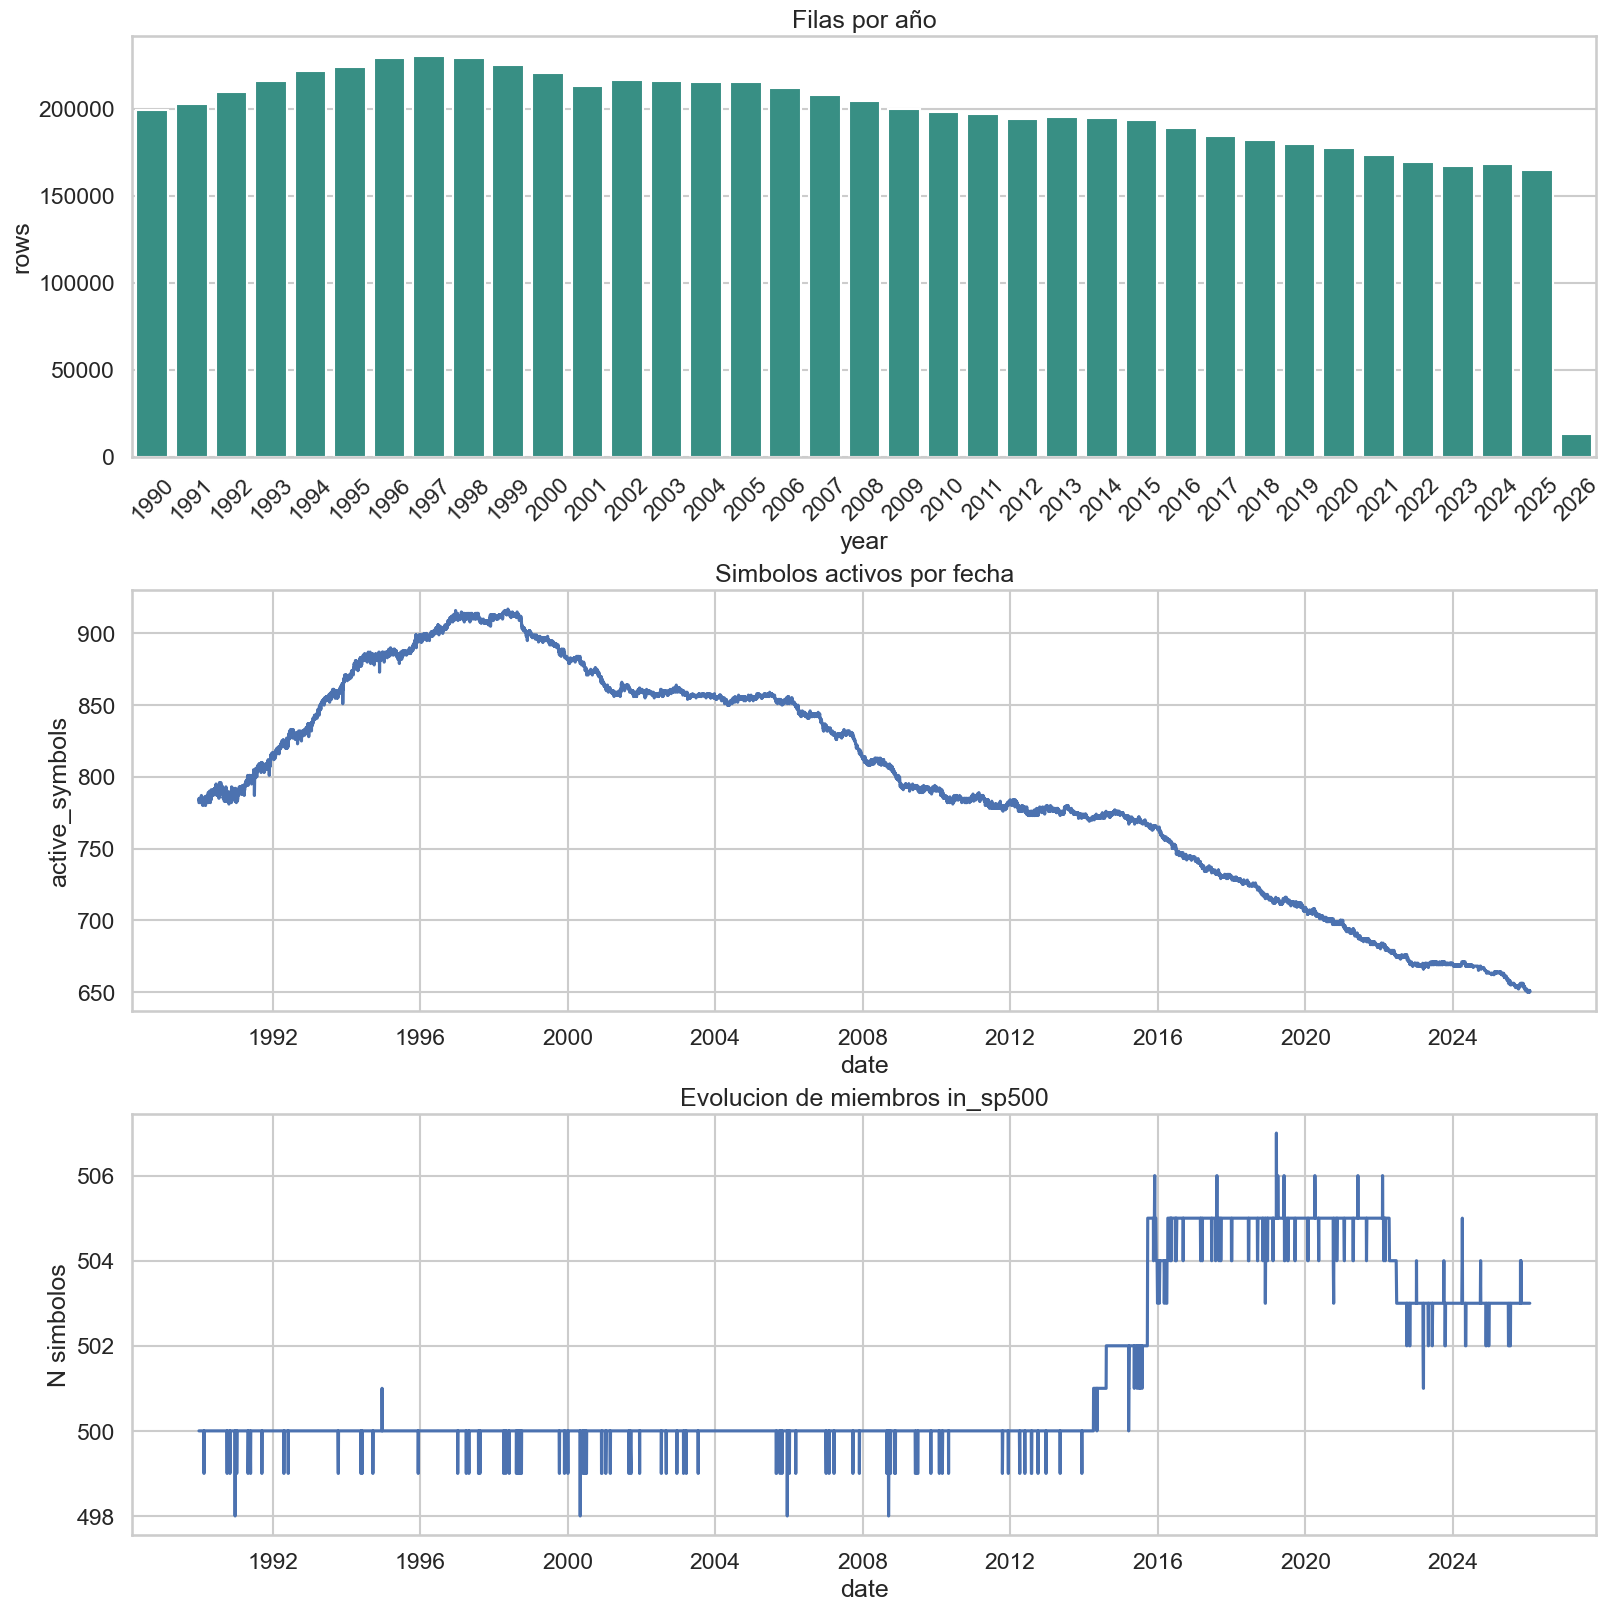

In [14]:
# EDA de cobertura: volumen temporal y amplitud del universo.
rows_by_year = (
    df.groupby(df["date"].dt.year, observed=True)
    .size()
    .rename("rows")
    .reset_index(name="rows")
    .rename(columns={"date": "year"})
)

rows_by_month = (
    df.assign(month=df["date"].dt.to_period("M").dt.to_timestamp("M"))
    .groupby("month", observed=True)
    .size()
    .rename("rows")
    .reset_index()
)

active_symbols_by_date = (
    df.groupby("date", observed=True)["symbol"]
    .nunique()
    .rename("active_symbols")
    .reset_index()
)

sp500_members_by_date = (
    df.loc[df["in_sp500"] == 1]
    .groupby("date", observed=True)["symbol"]
    .nunique()
    .rename("sp500_members")
    .reset_index()
)

print("Rows by year (head):")
print(rows_by_year.head(10).to_string(index=False))

fig, axes = plt.subplots(3, 1, figsize=(16, 16), constrained_layout=True)

sns.barplot(data=rows_by_year, x="year", y="rows", ax=axes[0], color="#2a9d8f")
axes[0].set_title("Filas por año")
axes[0].tick_params(axis="x", rotation=45)

sns.lineplot(data=active_symbols_by_date, x="date", y="active_symbols", ax=axes[1])
axes[1].set_title("Simbolos activos por fecha")

sns.lineplot(data=sp500_members_by_date, x="date", y="sp500_members", ax=axes[2])
axes[2].set_title("Evolucion de miembros in_sp500")
axes[2].set_ylabel("N simbolos")


## 4) EDA de Calidad y Gaps
### Nulos criticos y discontinuidades por simbolo
Se auditan nulos y huecos temporales para identificar riesgos de senales incompletas o ejecucion inconsistente.


Nulos por columna (top 10):
       column  null_count
    subsector      340662
     industry       15456
       sector        4968
       symbol           0
security_name           0
         date           0
      assetid           0
     in_sp500           0
         open           0
         high           0

Simbolos con mas filas criticas nulas (top 10):
      symbol  null_rows
         ZTS          0
           A          0
 AABA-201910          0
         AAL          0
  AAL-199702          0
AAMRQ-201312          0
         AAP          0
        AAPL          0
  AAV-199901          0
   XL-201809          0


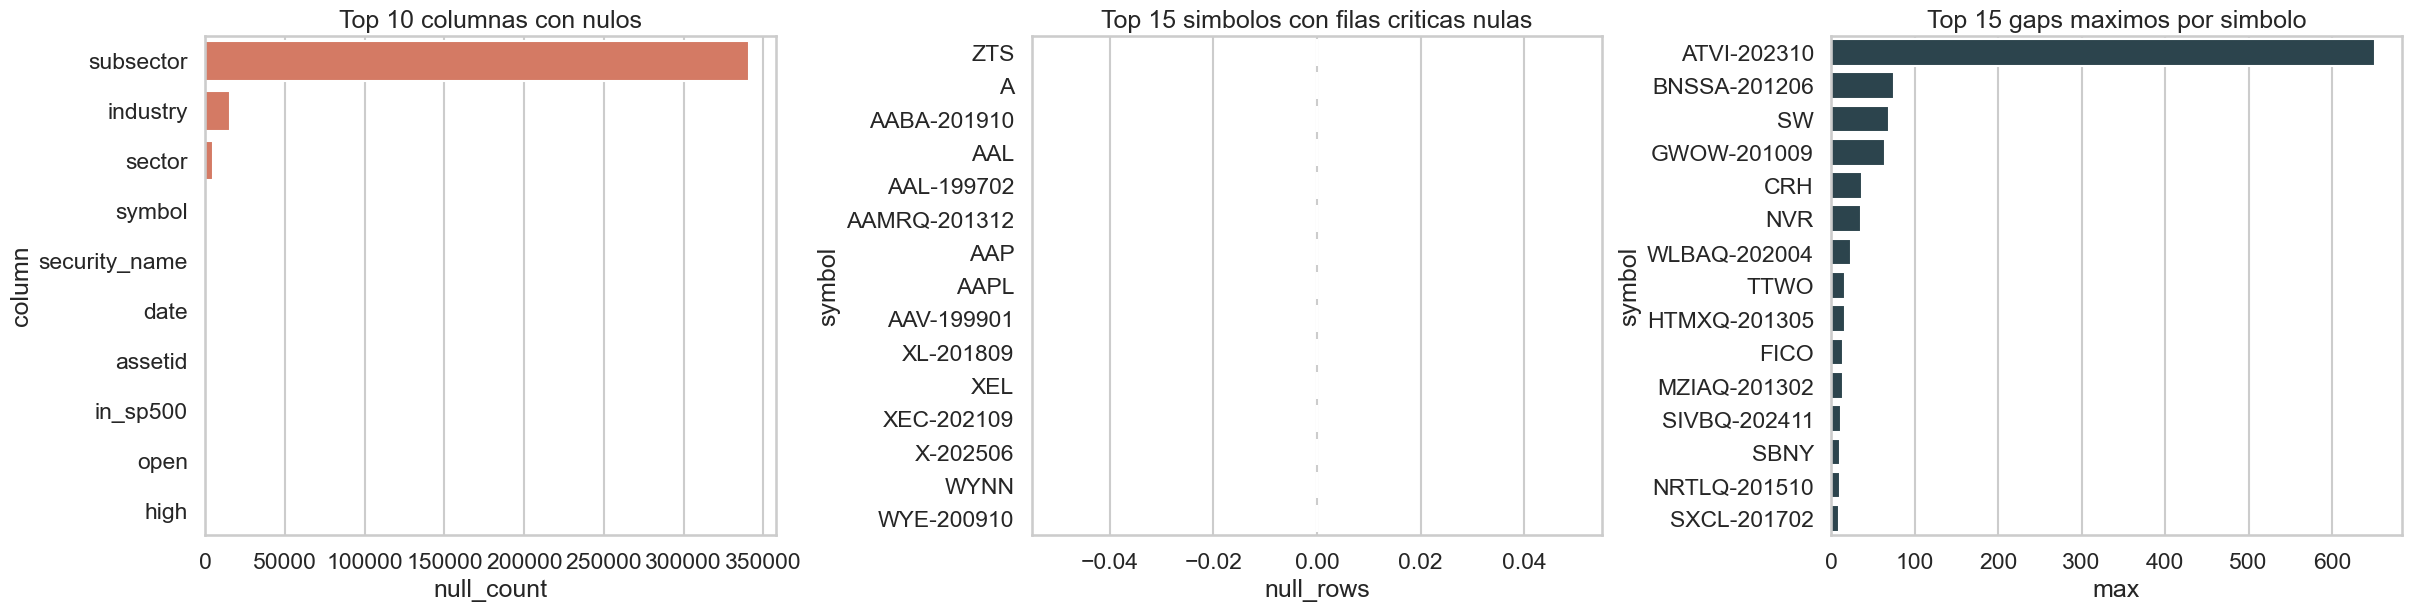

In [15]:
# EDA de calidad: nulos y gaps por simbolo.
nulls_by_column = (
    df.isna().sum().sort_values(ascending=False).rename("null_count").reset_index()
)
nulls_by_column.columns = ["column", "null_count"]

# Fila critica: si falta algun campo minimo para construir senales/ejecucion.
row_has_critical_null = df[CRITICAL_COLUMNS].isna().any(axis=1)
null_rows_by_symbol = (
    row_has_critical_null.groupby(df["symbol"], observed=True)
    .sum()
    .sort_values(ascending=False)
    .rename("null_rows")
    .reset_index()
)

null_rows_by_date = (
    row_has_critical_null.groupby(df["date"], observed=True)
    .sum()
    .sort_values(ascending=False)
    .rename("null_rows")
    .reset_index()
)

# Indice de sesiones para medir gaps contra calendario real de trading.
trade_calendar = pd.DataFrame(
    {"date": pd.Series(df["date"].drop_duplicates().sort_values().values)}
)
trade_calendar["trade_idx"] = np.arange(len(trade_calendar))

symbol_date_idx = (
    df[["symbol", "date"]]
    .drop_duplicates()
    .merge(trade_calendar, on="date", how="left")
    .sort_values(["symbol", "trade_idx"])
)

# Gap > 0 implica sesiones de mercado ausentes para ese simbolo.
symbol_date_idx["gap_size"] = (
    symbol_date_idx.groupby("symbol", observed=True)["trade_idx"].diff().fillna(1) - 1
)

gap_events = symbol_date_idx.loc[symbol_date_idx["gap_size"] > 0]
gaps_by_symbol = (
    gap_events.groupby("symbol", observed=True)["gap_size"]
    .agg(["count", "max"])
    .sort_values("max", ascending=False)
    .reset_index()
)

print("Nulos por columna (top 10):")
print(nulls_by_column.head(10).to_string(index=False))
print("\nSimbolos con mas filas criticas nulas (top 10):")
print(null_rows_by_symbol.head(10).to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(24, 6), constrained_layout=True)

sns.barplot(
    data=nulls_by_column.head(10),
    x="null_count",
    y="column",
    ax=axes[0],
    color="#e76f51",
)
axes[0].set_title("Top 10 columnas con nulos")

sns.barplot(
    data=null_rows_by_symbol.head(15),
    x="null_rows",
    y="symbol",
    ax=axes[1],
    color="#f4a261",
)
axes[1].set_title("Top 15 simbolos con filas criticas nulas")

if len(gaps_by_symbol) > 0:
    sns.barplot(
        data=gaps_by_symbol.head(15),
        x="max",
        y="symbol",
        ax=axes[2],
        color="#264653",
    )
    axes[2].set_title("Top 15 gaps maximos por simbolo")
else:
    axes[2].text(0.5, 0.5, "No hay gaps > 0", ha="center", va="center")
    axes[2].set_title("Gaps temporales")


## 5) EDA de Consistencia de Mercado
### Reglas economicas sobre OHLCV
Se valida plausibilidad de precios/volumen y coherencia OHLC para evitar datos imposibles en la simulacion.


Consistencia de mercado:
             metric  value
 invalid_price_rows      0
invalid_volume_rows      0
  invalid_ohlc_rows      0


([0, 1, 2],
 [Text(0, 0, 'invalid_price_rows'),
  Text(1, 0, 'invalid_volume_rows'),
  Text(2, 0, 'invalid_ohlc_rows')])

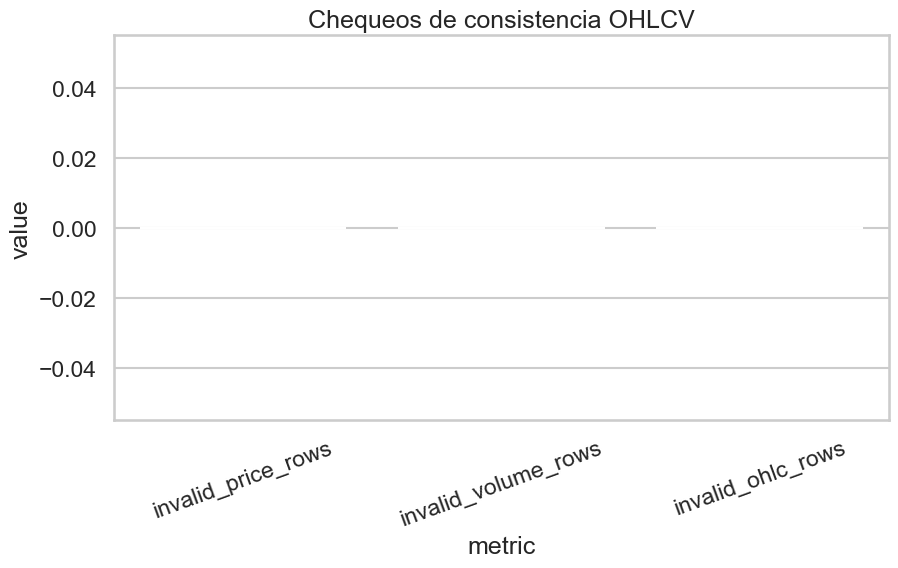

In [16]:
# EDA de consistencia de mercado: reglas economicas sobre OHLCV.
invalid_price_rows = int((df[["open", "high", "low", "close"]] <= 0).any(axis=1).sum())
invalid_volume_rows = int((df["volume"] < 0).sum())

high_inconsistency = df["high"] < df[["open", "close", "low"]].max(axis=1)
low_inconsistency = df["low"] > df[["open", "close", "high"]].min(axis=1)
invalid_ohlc_rows = int((high_inconsistency | low_inconsistency).sum())

consistency_summary = pd.DataFrame(
    {
        "metric": [
            "invalid_price_rows",
            "invalid_volume_rows",
            "invalid_ohlc_rows",
        ],
        "value": [invalid_price_rows, invalid_volume_rows, invalid_ohlc_rows],
    }
)

print("Consistencia de mercado:")
print(consistency_summary.to_string(index=False))

plt.figure(figsize=(10, 5))
sns.barplot(data=consistency_summary, x="metric", y="value", color="#6d597a")
plt.title("Chequeos de consistencia OHLCV")
plt.xticks(rotation=20)


## 6) EDA Descriptivo de Retornos
### Distribuciones diaria y mensual
Se caracterizan retornos logaritmicos (colas/outliers) para entender el comportamiento estadistico previo al modelado de senales.


Daily log returns summary:
count    7.248821e+06
mean     3.336802e-04
std      3.119803e-02
min     -6.288716e+00
1%      -7.480123e-02
5%      -3.636762e-02
50%      0.000000e+00
95%      3.729577e-02
99%      7.650851e-02
max      5.703783e+00

Monthly log returns summary:
count    345402.000000
mean          0.007202
std           0.124253
min          -6.443636
1%           -0.344648
5%           -0.166061
50%           0.011676
95%           0.169559
99%           0.306167
max           3.466298


Text(0.5, 0, 'log return')

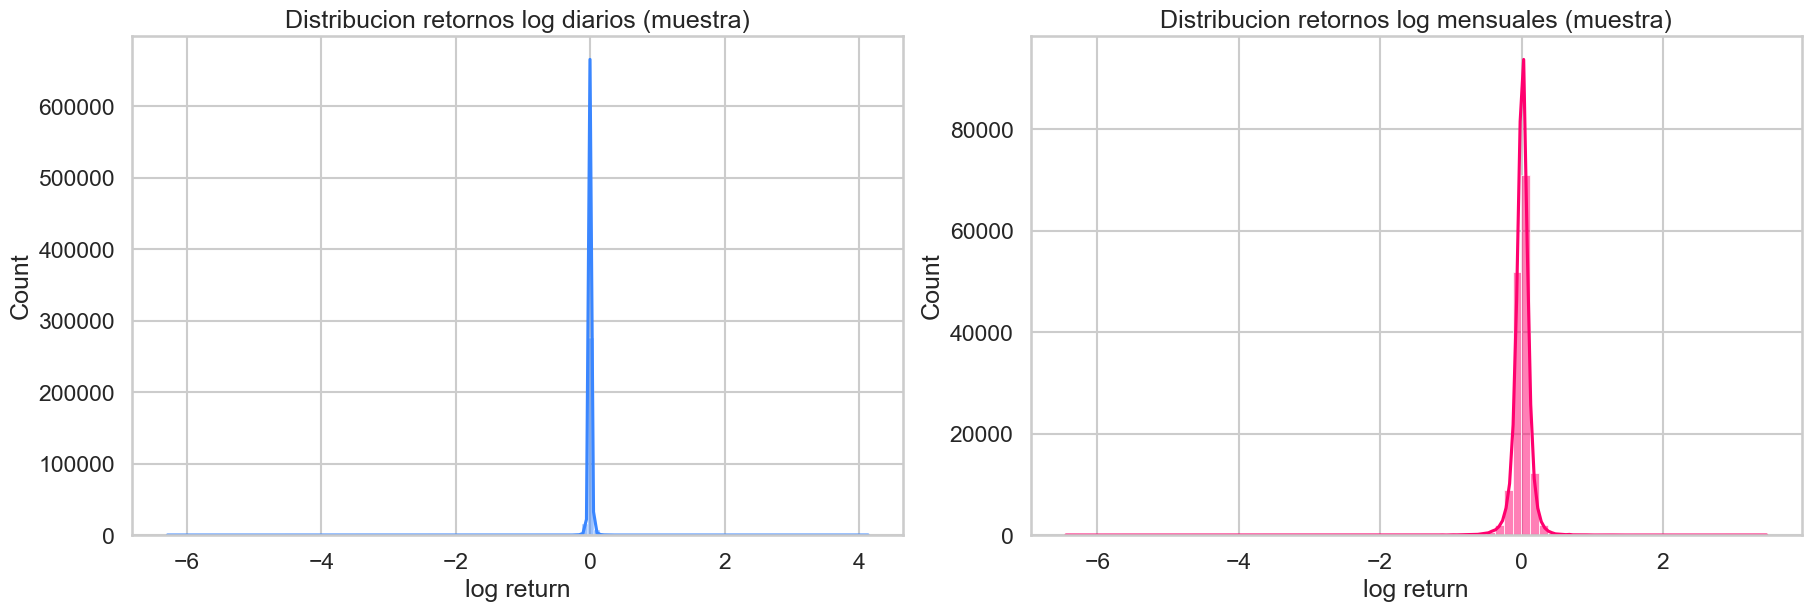

In [17]:
# EDA descriptivo de retornos: diarios y mensuales (sin senales finales).
price_panel = df[["symbol", "date", "close"]].sort_values(["symbol", "date"])

# Retorno log diario por simbolo: base estadistica para evaluar distribucion y colas.
price_panel["log_ret_1d"] = np.log(
    price_panel["close"]
    / price_panel.groupby("symbol", observed=True)["close"].shift(1)
)

daily_log_returns = (
    price_panel["log_ret_1d"].replace([np.inf, -np.inf], np.nan).dropna()
)

# Serie mensual por simbolo usando ultimo close disponible del mes.
monthly_close = (
    df[["symbol", "date", "close"]]
    .sort_values(["symbol", "date"])
    .assign(month=df["date"].dt.to_period("M"))
    .groupby(["symbol", "month"], observed=True)
    .tail(1)
    .rename(columns={"date": "month_end_date", "close": "month_end_close"})
)

monthly_close = monthly_close.sort_values(["symbol", "month_end_date"])
monthly_close["log_ret_1m"] = np.log(
    monthly_close["month_end_close"]
    / monthly_close.groupby("symbol", observed=True)["month_end_close"].shift(1)
)

monthly_log_returns = (
    monthly_close["log_ret_1m"].replace([np.inf, -np.inf], np.nan).dropna()
)

# Muestreo para graficar rapido sin perder forma global de la distribucion.
daily_sample_size = min(300000, len(daily_log_returns))
monthly_sample_size = min(150000, len(monthly_log_returns))

daily_sample = daily_log_returns.sample(n=daily_sample_size, random_state=42)
monthly_sample = monthly_log_returns.sample(n=monthly_sample_size, random_state=42)

print("Daily log returns summary:")
print(daily_log_returns.describe(percentiles=[0.01, 0.05, 0.95, 0.99]).to_string())
print("\nMonthly log returns summary:")
print(monthly_log_returns.describe(percentiles=[0.01, 0.05, 0.95, 0.99]).to_string())

fig, axes = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True)

sns.histplot(daily_sample, bins=120, kde=True, ax=axes[0], color="#3a86ff")
axes[0].set_title("Distribucion retornos log diarios (muestra)")
axes[0].set_xlabel("log return")

sns.histplot(monthly_sample, bins=80, kde=True, ax=axes[1], color="#ff006e")
axes[1].set_title("Distribucion retornos log mensuales (muestra)")
axes[1].set_xlabel("log return")


## 7) EDA de Cambios Abruptos de Cotizacion
### Deteccion de eventos extremos (1d, 5d, 10d)
Se etiquetan saltos extremos sin eliminar datos, se construye tabla de eventos para trazabilidad y se visualizan ranking/timeline/casos severos.


Umbrales de evento extremo:
|1d| >= 30.00% ; |5d| >= 60.00% ; |10d| >= 75.00%
Eventos detectados: 10067 | Tickers implicados: 603

Casuisticas detectadas:
caso_evento
Revisar manualmente                    8446
Distress/quiebra/delisting              926
Posible anomalia de dato                418
Corporate actions o ajuste mecanico     277

Muestra de eventos extremos:
      symbol fecha_evento  precio_t_1  precio_t  pct_cambio_1d  pct_cambio_5d  pct_cambio_10d  in_sp500      volumen                         caso_evento
  SBL-200701   1990-01-15    2.016693  1.366147     -32.258064     -36.363637             NaN         0 1.102535e+07                 Revisar manualmente
  GNE-199906   1990-02-02   21.750000 29.875000      37.356317      38.150287       41.420114         1 4.392400e+06                 Revisar manualmente
  ISS-199206   1990-02-05    0.500000  0.625000      25.000000     100.000000       42.857146         1 3.492000e+05                 Revisar manualmente
  ISS-199206   

,symbol,fecha_evento,precio_t_1,precio_t,pct_cambio_1d,pct_cambio_5d,pct_cambio_10d,in_sp500,volumen,caso_evento,severity_score
0,SBL-200701,1990-01-15,2.016693,1.366147,-32.258064,-36.363637,NaN,0,1.102535e+07,Revisar manualmente,1.075269
1,GNE-199906,1990-02-02,21.750000,29.875000,37.356317,38.150287,41.420114,1,4.392400e+06,Revisar manualmente,1.245211
2,ISS-199206,1990-02-05,0.500000,0.625000,25.000000,100.000000,42.857146,1,3.492000e+05,Revisar manualmente,1.666667
3,ISS-199206,1990-02-06,0.625000,0.500000,-19.999999,77.777779,45.454550,1,2.201000e+05,Revisar manualmente,1.296296
4,ISS-199206,1990-02-07,0.500000,0.625000,25.000000,100.000000,53.846157,1,1.955000e+05,Revisar manualmente,1.666667
5,ISS-199206,1990-02-08,0.625000,0.625000,0.000000,53.846157,81.818187,1,9.860000e+04,Revisar manualmente,1.090909
6,ISS-199206,1990-02-09,0.625000,0.437500,-30.000001,-12.500000,16.666663,1,4.816000e+05,Revisar manualmente,1.000000
7,CMVT-201302,1990-02-12,0.680956,0.907941,33.333337,0.000000,0.000000,0,1.885474e+05,Posible anomalia de dato,1.111111
8,ISS-199206,1990-02-13,0.468750,0.500000,6.666672,0.000000,77.777779,1,8.240000e+04,Revisar manualmente,1.037037
9,CMVT-201302,1990-03-01,0.680956,0.907941,33.333337,33.333337,0.000000,0,4.506348e+05,Revisar manualmente,1.111111


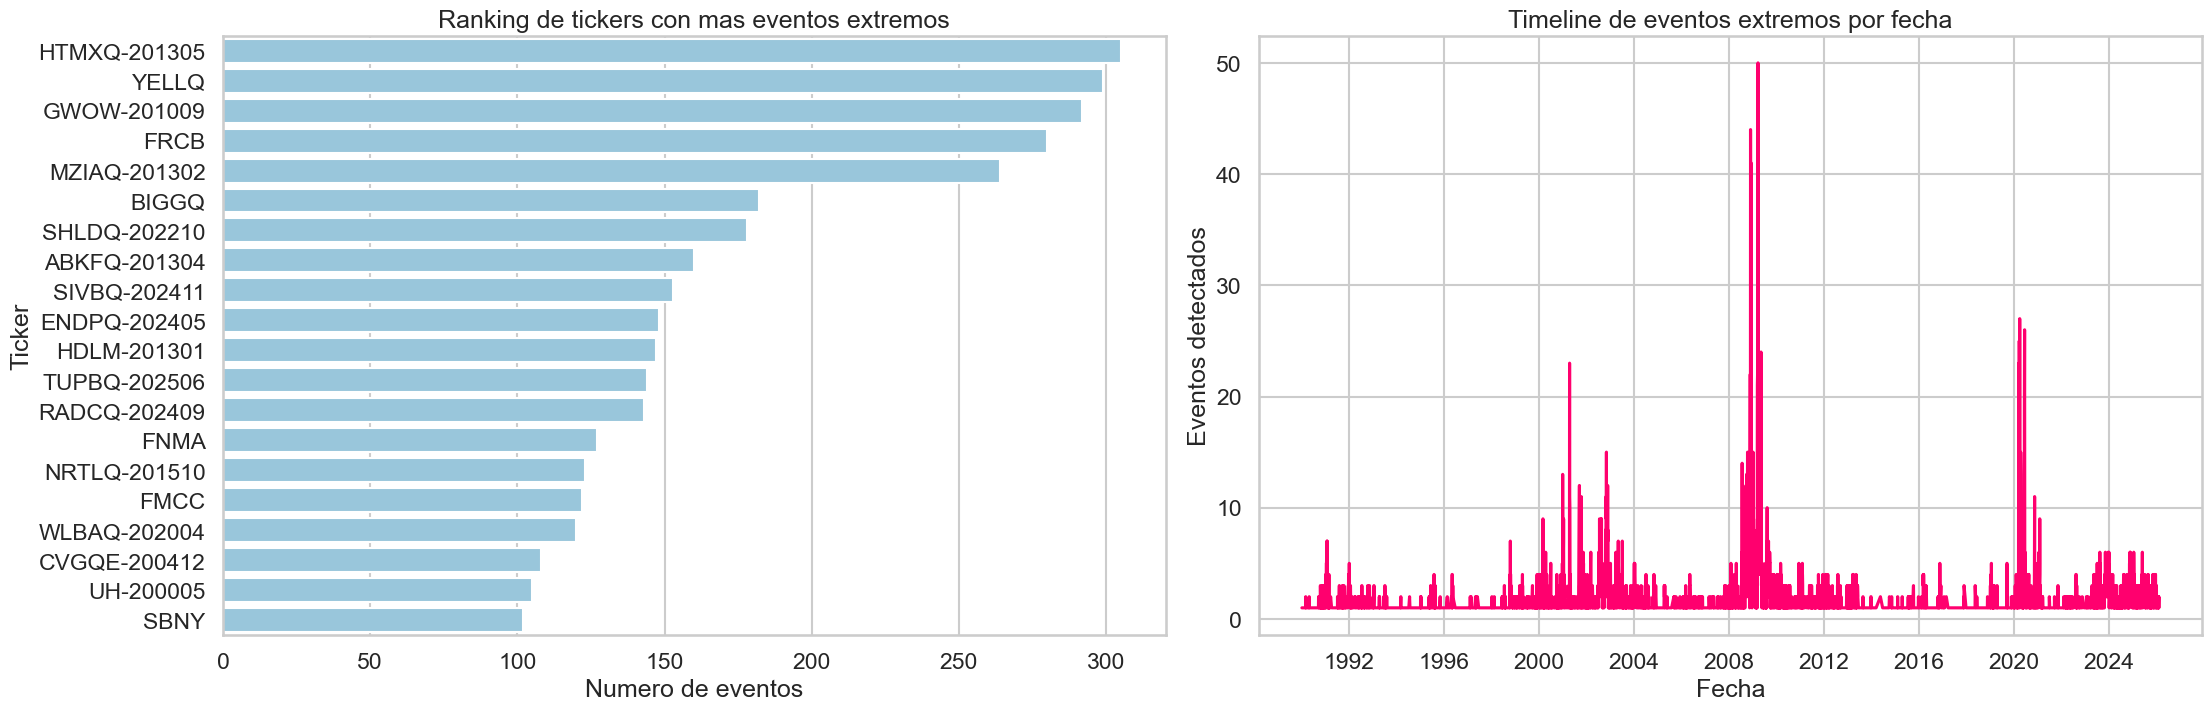

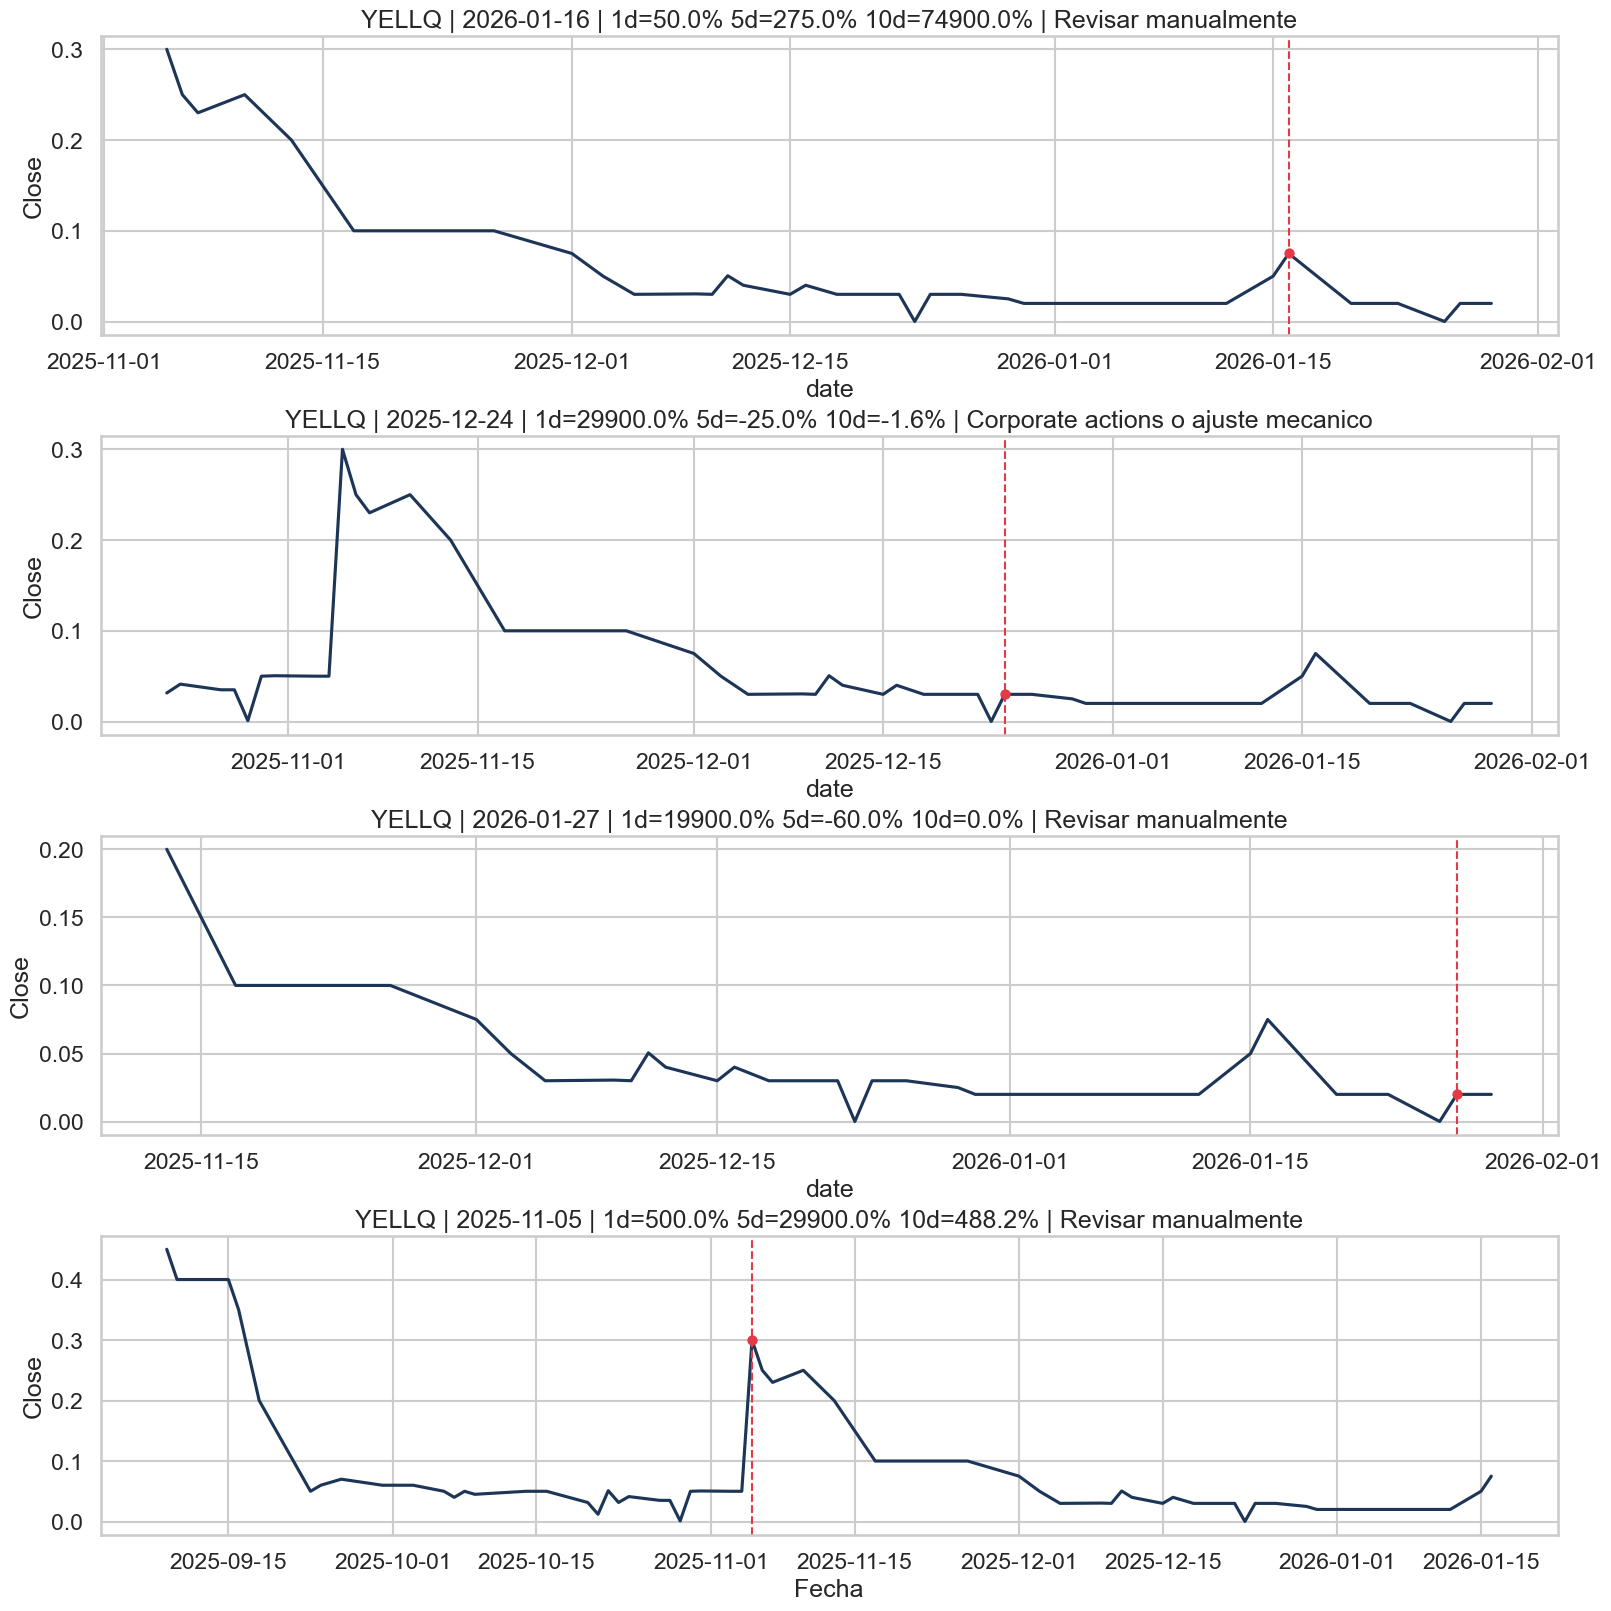

In [18]:
# EDA de cambios abruptos de cotizacion: deteccion y etiquetado de eventos extremos.
abrupt_panel = (
    df[["symbol", "date", "close", "in_sp500", "volume"]]
    .sort_values(["symbol", "date"])
    .copy()
)

abrupt_panel["precio_t_1"] = abrupt_panel.groupby("symbol", observed=True)["close"].shift(1)
abrupt_panel["ret_1d"] = (abrupt_panel["close"] / abrupt_panel["precio_t_1"]) - 1.0
abrupt_panel["ret_5d"] = (
    abrupt_panel["close"]
    / abrupt_panel.groupby("symbol", observed=True)["close"].shift(5)
) - 1.0
abrupt_panel["ret_10d"] = (
    abrupt_panel["close"]
    / abrupt_panel.groupby("symbol", observed=True)["close"].shift(10)
) - 1.0

for col in ["ret_1d", "ret_5d", "ret_10d"]:
    abrupt_panel[col] = abrupt_panel[col].replace([np.inf, -np.inf], np.nan)

# Umbrales robustos: maximo entre umbral fijo y cuantiles extremos.
threshold_1d = max(0.30, float(abrupt_panel["ret_1d"].abs().quantile(0.995)))
threshold_5d = max(0.60, float(abrupt_panel["ret_5d"].abs().quantile(0.995)))
threshold_10d = max(0.75, float(abrupt_panel["ret_10d"].abs().quantile(0.995)))

event_mask = (
    abrupt_panel["ret_1d"].abs().ge(threshold_1d)
    | abrupt_panel["ret_5d"].abs().ge(threshold_5d)
    | abrupt_panel["ret_10d"].abs().ge(threshold_10d)
)

def classify_abrupt_event(row: pd.Series) -> str:
    """Clasifica eventos extremos en casuisticas de interpretacion."""
    c1 = float(row.get("pct_cambio_1d", np.nan))
    c5 = float(row.get("pct_cambio_5d", np.nan))
    c10 = float(row.get("pct_cambio_10d", np.nan))

    if (c10 <= -80.0) or (c5 <= -70.0) or ((c1 <= -50.0) and (c5 <= -60.0)):
        return "Distress/quiebra/delisting"

    if (
        abs(c1) >= 45.0
        and abs(c5) <= 30.0
        and abs(c10) <= 40.0
    ):
        return "Corporate actions o ajuste mecanico"

    if (
        abs(c1) >= 30.0
        and np.sign(c1) != np.sign(c5)
        and abs(c5) <= 25.0
    ):
        return "Posible anomalia de dato"

    return "Revisar manualmente"

extreme_events = abrupt_panel.loc[
    event_mask,
    [
        "symbol",
        "date",
        "precio_t_1",
        "close",
        "ret_1d",
        "ret_5d",
        "ret_10d",
        "in_sp500",
        "volume",
    ],
].copy()

extreme_events = extreme_events.rename(
    columns={
        "date": "fecha_evento",
        "close": "precio_t",
        "volume": "volumen",
    }
)

extreme_events["pct_cambio_1d"] = extreme_events["ret_1d"] * 100.0
extreme_events["pct_cambio_5d"] = extreme_events["ret_5d"] * 100.0
extreme_events["pct_cambio_10d"] = extreme_events["ret_10d"] * 100.0

extreme_events["severity_score"] = np.nanmax(
    np.column_stack(
        [
            extreme_events["ret_1d"].abs() / threshold_1d,
            extreme_events["ret_5d"].abs() / threshold_5d,
            extreme_events["ret_10d"].abs() / threshold_10d,
        ]
    ),
    axis=1,
)

extreme_events["caso_evento"] = extreme_events.apply(
    classify_abrupt_event,
    axis=1,
)

# Tabla final pedida para inspeccion y trazabilidad.
abrupt_events_table = extreme_events[
    [
        "symbol",
        "fecha_evento",
        "precio_t_1",
        "precio_t",
        "pct_cambio_1d",
        "pct_cambio_5d",
        "pct_cambio_10d",
        "in_sp500",
        "volumen",
        "caso_evento",
        "severity_score",
    ]
].sort_values(["fecha_evento", "symbol"]).reset_index(drop=True)

print("Umbrales de evento extremo:")
print(
    (
        f"|1d| >= {threshold_1d:.2%} ; "
        f"|5d| >= {threshold_5d:.2%} ; "
        f"|10d| >= {threshold_10d:.2%}"
    )
)
print(
    (
        f"Eventos detectados: {len(abrupt_events_table)} | "
        f"Tickers implicados: {abrupt_events_table['symbol'].nunique()}"
    )
)

ranking_events = (
    abrupt_events_table.groupby("symbol", observed=True)
    .size()
    .sort_values(ascending=False)
    .head(20)
    .rename("n_eventos_extremos")
    .reset_index()
)

timeline_events = (
    abrupt_events_table.groupby("fecha_evento", observed=True)
    .size()
    .rename("n_eventos")
    .reset_index()
)

fig, axes = plt.subplots(1, 2, figsize=(22, 7), constrained_layout=True)

sns.barplot(
    data=ranking_events,
    x="n_eventos_extremos",
    y="symbol",
    ax=axes[0],
    color="#8ecae6",
)
axes[0].set_title("Ranking de tickers con mas eventos extremos")
axes[0].set_xlabel("Numero de eventos")
axes[0].set_ylabel("Ticker")

sns.lineplot(
    data=timeline_events,
    x="fecha_evento",
    y="n_eventos",
    ax=axes[1],
    color="#ff006e",
)
axes[1].set_title("Timeline de eventos extremos por fecha")
axes[1].set_xlabel("Fecha")
axes[1].set_ylabel("Eventos detectados")

# Ventanas de precio para eventos severos (contexto visual alrededor del salto).
top_severe = abrupt_events_table.nlargest(4, "severity_score")

if len(top_severe) > 0:
    fig, axes = plt.subplots(
        len(top_severe),
        1,
        figsize=(16, 4 * len(top_severe)),
        constrained_layout=True,
    )

    if len(top_severe) == 1:
        axes = [axes]

    for ax, (_, ev) in zip(axes, top_severe.iterrows()):
        sym = ev["symbol"]
        event_date = ev["fecha_evento"]
        sym_px = abrupt_panel.loc[
            abrupt_panel["symbol"] == sym,
            ["date", "close"],
        ].reset_index(drop=True)

        event_positions = sym_px.index[sym_px["date"] == event_date]
        if len(event_positions) == 0:
            continue

        pos = int(event_positions[0])
        left = max(0, pos - 30)
        right = min(len(sym_px), pos + 31)
        window_px = sym_px.iloc[left:right]

        sns.lineplot(data=window_px, x="date", y="close", ax=ax, color="#1d3557")
        ax.axvline(event_date, color="#e63946", linestyle="--", linewidth=1.5)
        ax.scatter(
            [event_date],
            [float(ev["precio_t"])],
            color="#e63946",
            s=35,
            zorder=3,
        )
        ax.set_title(
            (
                f"{sym} | {event_date.date()} | "
                f"1d={ev['pct_cambio_1d']:.1f}% "
                f"5d={ev['pct_cambio_5d']:.1f}% "
                f"10d={ev['pct_cambio_10d']:.1f}% | "
                f"{ev['caso_evento']}"
            )
        )
        ax.set_ylabel("Close")

    axes[-1].set_xlabel("Fecha")
else:
    print("No hay eventos extremos para los umbrales configurados.")

print("\nCasuisticas detectadas:")
print(abrupt_events_table["caso_evento"].value_counts().to_string())

print("\nMuestra de eventos extremos:")
print(
    abrupt_events_table[
        [
            "symbol",
            "fecha_evento",
            "precio_t_1",
            "precio_t",
            "pct_cambio_1d",
            "pct_cambio_5d",
            "pct_cambio_10d",
            "in_sp500",
            "volumen",
            "caso_evento",
        ]
    ].head(25).to_string(index=False)
)

abrupt_events_table.head(20)


### Casuisticas y Validacion Externa (agrupada)
- **Distress/quiebra/delisting**: caidas muy profundas y sostenidas en 5-10 dias.
  - Validar en: [Nasdaq Delisting](https://listingcenter.nasdaq.com/Delisting.aspx), [SEC EDGAR](https://www.sec.gov/edgar/searchedgar/companysearch.html), [OTC Markets](https://www.otcmarkets.com/).
- **Corporate actions (splits/reverse splits/ajustes)**: saltos fuertes de 1 dia con menor persistencia en 5-10 dias.
  - Validar en: [SEC Filings 8-K / 10-K](https://www.sec.gov/edgar/search/), [Nasdaq Corporate Actions](https://www.nasdaqtrader.com/Trader.aspx?id=CorporateActions), [Yahoo Finance - Historical Data](https://finance.yahoo.com/).
- **Posibles anomalias de dato**: picos aislados con reversion rapida o patron inconsistente.
  - Validar en: cruce con otro proveedor de precios, revision de splits y revision del volumen de ese dia.

### Como documentarlo en la memoria
Agrupa los tickers por `caso_evento` y resume por bloque: fecha(s), magnitud del movimiento, evidencia externa y conclusion (evento real vs ajuste tecnico vs posible anomalia).


## 8) EDA de Composicion del Universo
### Sectores e industrias
Se analiza la estructura sectorial del universo para identificar posibles sesgos de composicion a lo largo del tiempo.


Top sectores por promedio de miembros:
           Industrials
            Financials
Consumer Discretionary
Information Technology
           Health Care
      Consumer Staples
             Materials
             Utilities


Text(0.5, 0, 'N simbolos')

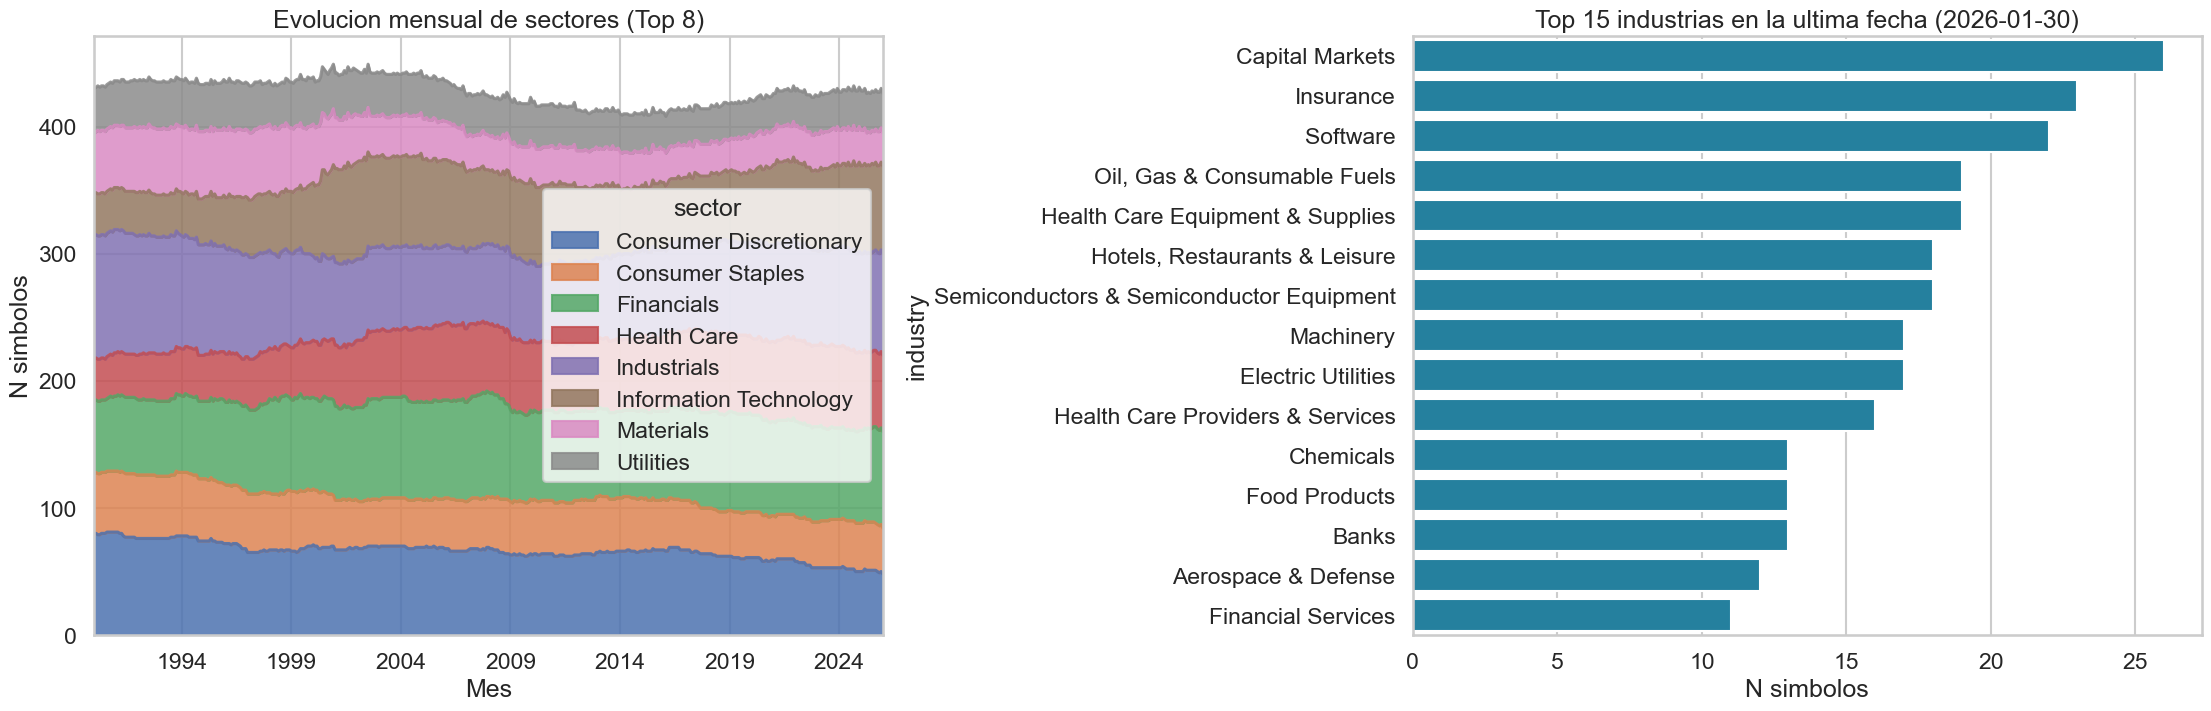

In [19]:
# EDA de composicion del universo: sectores e industrias.
sp500_df = df.loc[df["in_sp500"] == 1].copy()
sp500_df["month"] = sp500_df["date"].dt.to_period("M").dt.to_timestamp("M")

sector_monthly = (
    sp500_df.groupby(["month", "sector"], observed=True)["symbol"]
    .nunique()
    .rename("n_symbols")
    .reset_index()
)

top_sectors = (
    sector_monthly.groupby("sector", observed=True)["n_symbols"]
    .mean()
    .sort_values(ascending=False)
    .head(8)
    .index
)

sector_pivot = (
    sector_monthly.loc[sector_monthly["sector"].isin(top_sectors)]
    .pivot(index="month", columns="sector", values="n_symbols")
    .fillna(0)
)

latest_date = sp500_df["date"].max()
industry_latest = (
    sp500_df.loc[sp500_df["date"] == latest_date]
    .groupby("industry", observed=True)["symbol"]
    .nunique()
    .sort_values(ascending=False)
    .head(15)
    .rename("n_symbols")
    .reset_index()
)

print("Top sectores por promedio de miembros:")
print(pd.Series(top_sectors).to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(22, 7), constrained_layout=True)

sector_pivot.plot.area(ax=axes[0], alpha=0.85)
axes[0].set_title("Evolucion mensual de sectores (Top 8)")
axes[0].set_xlabel("Mes")
axes[0].set_ylabel("N simbolos")

sns.barplot(
    data=industry_latest,
    x="n_symbols",
    y="industry",
    ax=axes[1],
    color="#118ab2",
)
axes[1].set_title(f"Top 15 industrias en la ultima fecha ({latest_date.date()})")
axes[1].set_xlabel("N simbolos")


## 9) Regla Point-in-Time y Control de Look-Ahead
### Definicion operativa del universo elegible
Para cada fecha de rebalanceo `t` (ultimo dia habil de mes), un simbolo es elegible si tuvo `in_sp500 = 1` al menos una vez en la ventana mensual `[t-13, t-1]`.

### Motivo y salida esperada
Esta regla evita usar informacion futura y deja listo el calendario/lags que luego consume N3 para calcular momentum con retardo de 1 mes.


In [20]:
def build_rebalance_calendar(
    canonical_df: pd.DataFrame,
    backtest_start: str,
) -> pd.DataFrame:
    """Genera ultimo dia habil de cada mes y referencias t-1, t-7, t-13."""
    unique_dates = pd.DataFrame(
        {"date": pd.Series(canonical_df["date"].drop_duplicates().sort_values().values)}
    )

    # Ultimo dia con mercado por mes: fecha efectiva de rebalanceo.
    calendar = (
        unique_dates.assign(month=unique_dates["date"].dt.to_period("M"))
        .groupby("month", observed=True)["date"]
        .max()
        .reset_index()
        .rename(columns={"date": "rebalance_date"})
        .sort_values("rebalance_date")
        .reset_index(drop=True)
    )

    # Recortamos al periodo oficial de backtest.
    calendar = calendar.loc[
        calendar["rebalance_date"] >= pd.Timestamp(backtest_start)
    ].reset_index(drop=True)

    # Lags mensuales que N3 necesita para R6 y R12 con lag-1.
    calendar["lag_1_date"] = calendar["rebalance_date"].shift(1)
    calendar["lag_7_date"] = calendar["rebalance_date"].shift(7)
    calendar["lag_13_date"] = calendar["rebalance_date"].shift(13)
    calendar["has_required_lags"] = (
        calendar[["lag_1_date", "lag_7_date", "lag_13_date"]].notna().all(axis=1)
    )
    return calendar


def build_membership_flag(
    canonical_df: pd.DataFrame,
    rebalance_calendar: pd.DataFrame,
) -> pd.DataFrame:
    """Marca simbolos en S&P en [t-13, t-1] con enfoque vectorizado."""
    monthly_membership = (
        canonical_df.assign(month=canonical_df["date"].dt.to_period("M"))
        .groupby(["symbol", "month"], observed=True)["in_sp500"]
        .max()
        .reset_index()
    )

    # Construimos panel simbolo-mes completo para evitar sesgo por meses ausentes.
    month_min = monthly_membership["month"].min()
    month_max = monthly_membership["month"].max()
    all_months = pd.period_range(month_min, month_max, freq="M")
    all_symbols = monthly_membership["symbol"].drop_duplicates().sort_values()

    full_index = pd.MultiIndex.from_product(
        [all_symbols, all_months],
        names=["symbol", "month"],
    )

    monthly_full = (
        monthly_membership.set_index(["symbol", "month"])["in_sp500"]
        .reindex(full_index, fill_value=0)
        .rename("in_sp500")
        .reset_index()
        .sort_values(["symbol", "month"])
        .reset_index(drop=True)
    )

    # shift(1): excluye el mes actual de rebalanceo para evitar look-ahead.
    prev_membership = (
        monthly_full.groupby("symbol", observed=True)["in_sp500"]
        .shift(1)
        .fillna(0)
    )

    # rolling(13).max(): estuvo al menos una vez en S&P durante 13 meses previos.
    rolling_13m = prev_membership.groupby(
        monthly_full["symbol"],
        observed=True,
    ).transform(lambda s: s.rolling(window=13, min_periods=1).max())

    monthly_full["in_sp500_last_13m"] = rolling_13m > 0

    rebalance_months = rebalance_calendar[["rebalance_date"]].copy()
    rebalance_months["month"] = rebalance_months["rebalance_date"].dt.to_period("M")

    membership_flag = (
        monthly_full.loc[
            monthly_full["in_sp500_last_13m"],
            ["symbol", "month"],
        ]
        .merge(rebalance_months, on="month", how="inner")
        [["rebalance_date", "symbol"]]
        .drop_duplicates()
        .assign(in_sp500_last_13m=True)
    )

    return membership_flag


def optimize_table_dtypes(
    table: pd.DataFrame,
    float_columns: list[str],
    category_columns: list[str],
) -> pd.DataFrame:
    """Reduce memoria de tablas de salida sin cambiar semantica."""
    optimized = table.copy()

    for col in float_columns:
        if col in optimized.columns:
            optimized[col] = pd.to_numeric(optimized[col], errors="coerce")
            optimized[col] = pd.to_numeric(optimized[col], downcast="float")

    for col in category_columns:
        if col in optimized.columns:
            optimized[col] = optimized[col].astype("category")

    return optimized


def build_preparation_tables(
    canonical_df: pd.DataFrame,
    rebalance_calendar: pd.DataFrame,
    membership_flag: pd.DataFrame,
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, dict]:
    """Construye inputs N3/N4 con grid optimizado por universo elegible."""
    calendar_keys = [
        "rebalance_date",
        "lag_1_date",
        "lag_7_date",
        "lag_13_date",
        "has_required_lags",
    ]
    calendar_view = rebalance_calendar[calendar_keys]

    # Optimizacion clave: evitamos calendario x todos los simbolos.
    base_grid = (
        membership_flag[["rebalance_date", "symbol"]]
        .merge(calendar_view, on="rebalance_date", how="inner")
        .drop_duplicates(["rebalance_date", "symbol"])
    )

    # Precios close de referencia para lags de senales en N3.
    close_px = canonical_df[["date", "symbol", "close"]]
    lag_1_px = close_px.rename(columns={"date": "lag_1_date", "close": "close_t1"})
    lag_7_px = close_px.rename(columns={"date": "lag_7_date", "close": "close_t7"})
    lag_13_px = close_px.rename(columns={"date": "lag_13_date", "close": "close_t13"})

    signals_input = (
        base_grid.merge(lag_1_px, on=["symbol", "lag_1_date"], how="left")
        .merge(lag_7_px, on=["symbol", "lag_7_date"], how="left")
        .merge(lag_13_px, on=["symbol", "lag_13_date"], how="left")
    )

    # Snapshot de precios para simulacion operativa de N4 (open/close del rebalance).
    exec_snapshot = canonical_df[
        [
            "date",
            "symbol",
            "open",
            "close",
            "high",
            "low",
            "volume",
            "sector",
            "industry",
        ]
    ].rename(
        columns={
            "date": "rebalance_date",
            "open": "open_rebalance",
            "close": "close_rebalance",
            "high": "high_rebalance",
            "low": "low_rebalance",
            "volume": "volume_rebalance",
            "sector": "sector_rebalance",
            "industry": "industry_rebalance",
        }
    )

    signals_input = signals_input.merge(
        exec_snapshot,
        on=["rebalance_date", "symbol"],
        how="left",
    )

    # Esta tabla ya parte de membership_flag, por eso la bandera es True.
    signals_input["in_sp500_last_13m"] = True

    # Flags de calidad para separar elegibilidad de senales y de ejecucion.
    signals_input["has_complete_lag_prices"] = signals_input[
        ["close_t1", "close_t7", "close_t13"]
    ].notna().all(axis=1)

    signals_input["has_execution_prices"] = signals_input[
        ["open_rebalance", "close_rebalance"]
    ].notna().all(axis=1)

    signals_input["has_positive_execution_prices"] = (
        (signals_input["open_rebalance"] > 0)
        & (signals_input["close_rebalance"] > 0)
    )

    signals_input["eligible_for_signals"] = (
        signals_input["has_required_lags"]
        & signals_input["has_complete_lag_prices"]
        & signals_input["in_sp500_last_13m"]
    )

    signals_input["eligible_for_execution"] = (
        signals_input["eligible_for_signals"]
        & signals_input["has_execution_prices"]
        & signals_input["has_positive_execution_prices"]
    )

    pre_opt_bytes = int(signals_input.memory_usage(deep=True).sum())

    # Downcast/categorias para acelerar I/O y reducir consumo de memoria.
    signals_input = optimize_table_dtypes(
        table=signals_input,
        float_columns=[
            "close_t1",
            "close_t7",
            "close_t13",
            "open_rebalance",
            "close_rebalance",
            "high_rebalance",
            "low_rebalance",
            "volume_rebalance",
        ],
        category_columns=["symbol", "sector_rebalance", "industry_rebalance"],
    )

    eligibility_flags = signals_input[
        [
            "rebalance_date",
            "symbol",
            "has_required_lags",
            "in_sp500_last_13m",
            "has_complete_lag_prices",
            "has_execution_prices",
            "has_positive_execution_prices",
            "eligible_for_signals",
            "eligible_for_execution",
        ]
    ].copy()

    execution_prices = signals_input[
        [
            "rebalance_date",
            "symbol",
            "open_rebalance",
            "close_rebalance",
            "high_rebalance",
            "low_rebalance",
            "volume_rebalance",
            "eligible_for_execution",
        ]
    ].copy()

    post_opt_bytes = int(signals_input.memory_usage(deep=True).sum())
    full_grid_rows = int(len(rebalance_calendar) * canonical_df["symbol"].nunique())
    optimized_grid_rows = int(len(base_grid))
    grid_reduction_pct = 100 * (1 - (optimized_grid_rows / full_grid_rows))

    optimization_stats = {
        "full_grid_rows": full_grid_rows,
        "optimized_grid_rows": optimized_grid_rows,
        "grid_reduction_pct": float(grid_reduction_pct),
        "signals_bytes_before": pre_opt_bytes,
        "signals_bytes_after": post_opt_bytes,
    }

    return signals_input, eligibility_flags, execution_prices, optimization_stats


## 10) Construccion de Artefactos para N3/N4
### Calendario, elegibilidad y tablas operativas
Se construyen y exportan tablas de entrada para senales y ejecucion, junto con checks de calidad de etapa.


Checklist N2:
                    item  passed
       all_checks_passed    True
   signals_input_created    True
     eligibility_created    True
execution_prices_created    True
        calendar_created    True

Artefactos exportados:
 rebalance_calendar_csv  eligibility_flags_parquet  signals_input_parquet  execution_prices_parquet  eda_checks_csv
                   True                       True                   True                      True            True

Muestra rebalance calendar:
  month rebalance_date lag_1_date lag_7_date lag_13_date  has_required_lags
2015-01     2015-01-30        NaT        NaT         NaT              False
2015-02     2015-02-27 2015-01-30        NaT         NaT              False
2015-03     2015-03-31 2015-02-27        NaT         NaT              False
2015-04     2015-04-30 2015-03-31        NaT         NaT              False
2015-05     2015-05-29 2015-04-30        NaT         NaT              False

Optimization stats:
 full_grid_rows  optimized

Text(0, 0.5, 'N simbolos')

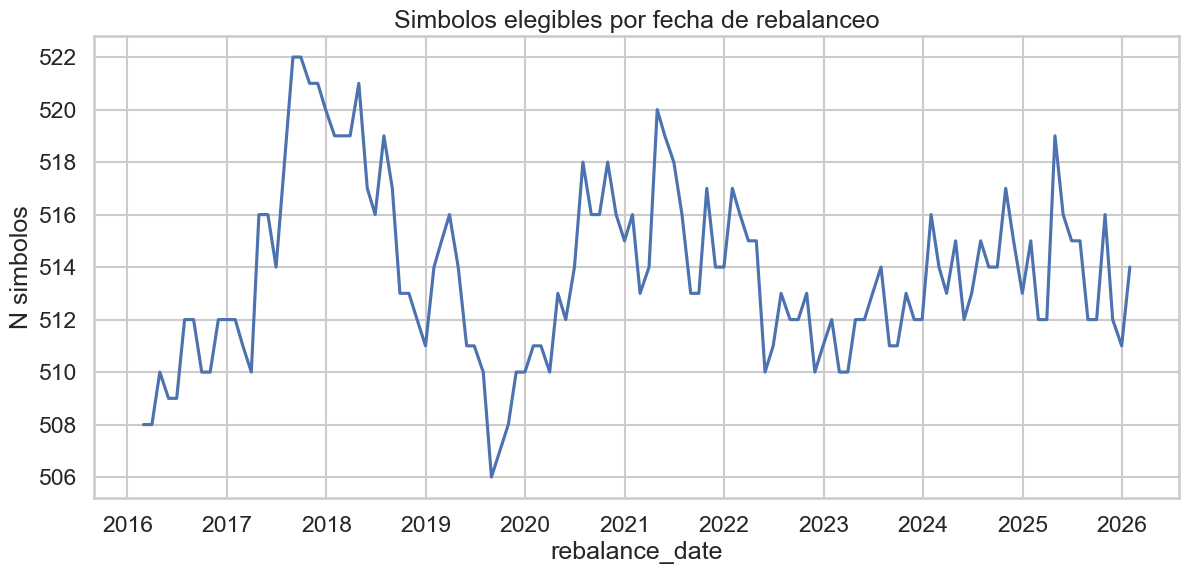

In [21]:
# Orquestacion final de la preparacion N2.
backtest_start = runtime_params.get("backtest_start", "2015-01-01")

rebalance_calendar = build_rebalance_calendar(df, backtest_start=backtest_start)
membership_flag = build_membership_flag(df, rebalance_calendar)
(
    signals_input,
    eligibility_flags,
    execution_prices,
    optimization_stats,
) = build_preparation_tables(
    canonical_df=df,
    rebalance_calendar=rebalance_calendar,
    membership_flag=membership_flag,
)

# Checks de preparacion para dejar listo N3.
n2_stage_checks = []
record_check(
    n2_stage_checks,
    "rebalance_calendar_not_empty",
    len(rebalance_calendar) > 0,
    f"rows={len(rebalance_calendar)}",
)
record_check(
    n2_stage_checks,
    "rebalance_has_lag_window",
    bool(rebalance_calendar["has_required_lags"].any()),
    f"rows_with_lags={int(rebalance_calendar['has_required_lags'].sum())}",
)

duplicate_signals = int(signals_input.duplicated(["rebalance_date", "symbol"]).sum())
record_check(
    n2_stage_checks,
    "signals_unique_key",
    duplicate_signals == 0,
    f"duplicate_rows={duplicate_signals}",
)

eligible_count = int(signals_input["eligible_for_signals"].sum())
record_check(
    n2_stage_checks,
    "signals_have_eligible_rows",
    eligible_count > 0,
    f"eligible_rows={eligible_count}",
)

execution_non_null = int(execution_prices["open_rebalance"].notna().sum())
record_check(
    n2_stage_checks,
    "execution_prices_available",
    execution_non_null > 0,
    f"non_null_open_rows={execution_non_null}",
)

# Check no critico: solo audita mejora de eficiencia del grid.
record_check(
    n2_stage_checks,
    "optimized_grid_reduction",
    optimization_stats["optimized_grid_rows"] < optimization_stats["full_grid_rows"],
    (
        f"optimized_rows={optimization_stats['optimized_grid_rows']} "
        f"full_rows={optimization_stats['full_grid_rows']}"
    ),
    critical=False,
)

n2_stage_checks_df = pd.DataFrame(n2_stage_checks)
n2_checks_df = pd.concat([n2_checks_df, n2_stage_checks_df], ignore_index=True)

# Exportes finales que consumiran N3 y N4.
rebalance_calendar.to_csv(OUT_REBALANCE_CALENDAR, index=False)
eligibility_flags.to_parquet(OUT_ELIGIBILITY_FLAGS, engine="pyarrow", index=False)
signals_input.to_parquet(OUT_SIGNALS_INPUT, engine="pyarrow", index=False)
execution_prices.to_parquet(OUT_EXECUTION_PRICES, engine="pyarrow", index=False)
n2_checks_df.to_csv(OUT_EDA_CHECKS, index=False)

artifacts_status = {
    "rebalance_calendar_csv": pd.io.common.file_exists(OUT_REBALANCE_CALENDAR),
    "eligibility_flags_parquet": pd.io.common.file_exists(OUT_ELIGIBILITY_FLAGS),
    "signals_input_parquet": pd.io.common.file_exists(OUT_SIGNALS_INPUT),
    "execution_prices_parquet": pd.io.common.file_exists(OUT_EXECUTION_PRICES),
    "eda_checks_csv": pd.io.common.file_exists(OUT_EDA_CHECKS),
}

ready_for_n3 = {
    "all_checks_passed": bool(n2_checks_df["passed"].all()),
    "signals_input_created": artifacts_status["signals_input_parquet"],
    "eligibility_created": artifacts_status["eligibility_flags_parquet"],
    "execution_prices_created": artifacts_status["execution_prices_parquet"],
    "calendar_created": artifacts_status["rebalance_calendar_csv"],
}

ready_df = pd.DataFrame(
    [{"item": key, "passed": value} for key, value in ready_for_n3.items()]
)

# Si algo falla aqui, N3 no debe arrancar.
fail_if(
    not all(ready_for_n3.values()),
    "N2 readiness FAILED: revisar checks y exportes.",
)

eligible_by_rebalance = (
    signals_input.loc[signals_input["eligible_for_signals"]]
    .groupby("rebalance_date", observed=True)["symbol"]
    .nunique()
    .rename("eligible_symbols")
    .reset_index()
)

print("Checklist N2:")
print(ready_df.to_string(index=False))
print("\nArtefactos exportados:")
print(pd.DataFrame([artifacts_status]).to_string(index=False))
print("\nMuestra rebalance calendar:")
print(rebalance_calendar.head(5).to_string(index=False))
print("\nOptimization stats:")
print(pd.DataFrame([optimization_stats]).to_string(index=False))

plt.figure(figsize=(14, 6))
sns.lineplot(data=eligible_by_rebalance, x="rebalance_date", y="eligible_symbols")
plt.title("Simbolos elegibles por fecha de rebalanceo")
plt.ylabel("N simbolos")


## 11) Readiness Final de N2
### Verificacion de continuidad
Se imprime checklist final y muestras de salida para confirmar que N3 puede arrancar sin bloqueos.


In [22]:
print("DATA READINESS N2: PASS. El proyecto puede continuar en Notebook_3.")
print("\nChecks N2:")
print(n2_checks_df.to_string(index=False))

print("\nSignals input sample:")
sample_cols = [
    "rebalance_date",
    "symbol",
    "lag_1_date",
    "lag_7_date",
    "lag_13_date",
    "close_t1",
    "close_t7",
    "close_t13",
    "in_sp500_last_13m",
    "eligible_for_signals",
]
print(signals_input[sample_cols].head(10).to_string(index=False))


DATA READINESS N2: PASS. El proyecto puede continuar en Notebook_3.

Checks N2:
                            check  passed  critical                                                 details
       canonical_required_columns    True      True                                      missing_columns=[]
             spy_required_columns    True      True                                      missing_columns=[]
     canonical_date_symbol_unique    True      True                                        duplicate_rows=0
canonical_contains_backtest_start    True      True           date_max=2026-01-30 backtest_start=2015-01-01
         canonical_has_13m_warmup    True      True          date_min=1990-01-02 required_before=2013-12-01
              spy_start_alignment    True      True spy_min=2015-01-02 backtest_start=2015-01-01 gap_days=1
           spy_has_useful_horizon    True      True                           days_from_backtest_start=4067
     rebalance_calendar_not_empty    True      True     

## 12) Resumen Final de N2
### Resultado del notebook
Se validaron entradas de N1, se ejecutaron EDA clave (incluyendo cambios abruptos), y se exportaron artefactos consistentes para N3/N4 con checks de calidad y readiness.
